## Background
Buckling is a common failure mode for columns and other slender structures in compression. 

The concept of "buckling length" is often used in practical design of columns. The buckled shapes that can be derived from Euler-Bernoulli beam theory are sinusoids, and the buckling length is some fraction (half?) of a full sine wave. 

Mechanics textbooks and formula sheets contain figures like this (this one is taken from a formula sheet from the Norwegian University of Science and Technology):

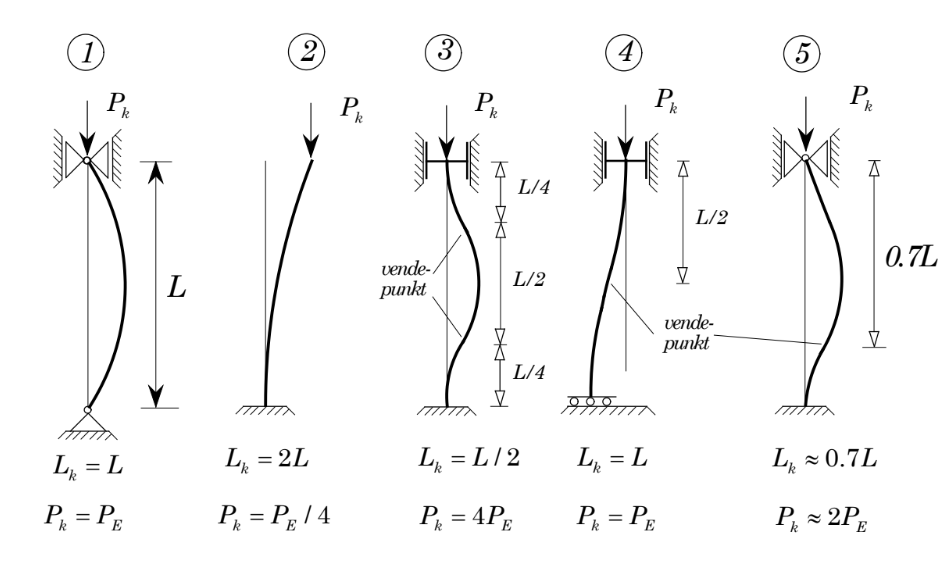

Where the buckling lengths and buckling loads are given for a few canonical cases that differ in their boundary conditions.

Also given will be the "Euler buckling load" which is 

$P_E = \frac{\pi^2 E I}{L_E^2}$

Where $L_E$ is the buckling length.

As is obvious from the buckling load formula, the cross section (represented by the second moment of area $I$) is constant over the length of the column, so this formula is not directly applicableto columns with variable cross sections. 

However, consider a utility pole:

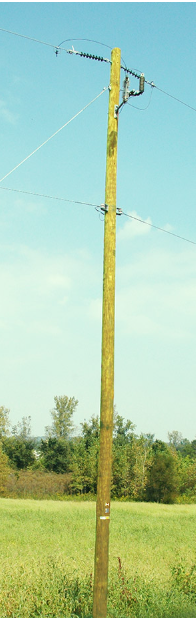

What is the buckling load? Approximating it as constant diameter using the average diameter is one option, which may or may not be conservative. Or would that be the average moment of inertia? Since the second moment of area is the diameter to the fourth power, a factor of 1.5 between the bottom and top diameters means a factor of $1.5^4 \approx 5$ between the local bending stiffnesses. 

## Numerical solution

Fortunately,the finite element method can solve any buckling problem like this numerically. In my experience, the finite element method is underutilized for buckling problems even though it is widely used for force/displacement-type problems. 

Let's analyze this problem in Python using the finite element method.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


# Stiffness matrix of a beam element with two dofs (transverse displacement and rotation) per node, 
# elastic modulus E, second moment of area I, length L
def beam_stiffness(E, I, L):
    return E*I/L**3 * np.array([
        [12, 6*L, -12, 6*L], 
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]])

# Geometric stiffness matrix, to be multiplied by the axial load P
# This doesn't even depend on E or I, but I want the function signatures to match
def beam_stiffness_geometric(E, I, L):
    return 1/L * np.array([
            [6/5, L/10, -6/5, L/10],
            [L/10, 2*L**2/15, -L/10, -L**2/30],
            [-6/5, -L/10, 6/5, -L/10],
            [L/10, -L**2/30, -L/10, 2*L**2/15]])

A buckling analysis is done by solving the eigenvalue problem 

$ det(\textbf{K} - P \textbf{K}_g) = 0 $

Wherein $\textbf{K}$ and $\textbf{K}_g$ are assembled stiffness matrices with boundary conditions applied (without boundary conditions, $\textbf{K}$ will be singular all by itself). The eigenvalues $P$ will be the buckling loads and the eigenvectors will be the buckling shapes corresponding to the buckling loads. Usually, only the smallest buckling load is of interest.

We need to analyze with multiple elements; Since every element has a constant cross section and material stiffness, we need several elements to capture the global variation, and the approxmation will be better the more elements we use. Assembly of the stiffness of multiple elements is done by inserting the elements of the element stiffness matrices into the global stiffness matrix with the element dofs dictating where the matrix elements go. Since we are modeling single columns, the elements just lie one after another assembly is easy.

In [86]:
def assemble_stiffness(E, r1, r2, L, nelem, elem_func):
    ndofs = 2 * (nelem + 1)
    yy = np.linspace(0, L, nelem + 1)
    K = np.zeros((ndofs, ndofs))
    for i,y1,y2 in zip(range(nelem), yy, yy[1:]):
        r1_element = r1 + (r2-r1)/L * y1
        r2_element = r1 + (r2-r1)/L * y2
        I = np.pi/4 * (0.5*(r1_element + r2_element))**4
        k_i = elem_func(E, I, y2-y1)
        elem_dofs = [2*i, 2*i+1, 2*i+2, 2*i+3]
        K[np.ix_(elem_dofs, elem_dofs)] += k_i
        
    return K

The function above creates a stiffness matrix for an assembly of $nelem$ elements between $y=0$ and $y=L$ with bottom radius r1 and top radius r2. There are $nelem+1$ nodes evenly spaced; The bottom one has global dofs 0 and 1, the second one 2 and 3, and so on. Every element has a radius which is the average radius of the column over the length of the element. The numpy.ix_ function creates exactly the indices needed to index into the global matrix for finite element assembly. 

We need to apply boundary conditions to get a solution. The nodes each have two degrees of freedom: Transverse displacement and rotation. We are only applying boundary conditions to the ends, meaning that we will constrain the first two and the last two global dofs, which are the displacement and rotation at the bottom and the top, respectively. We'll make a list of constrained dofs for each of the five canonical cases given above. 

In [3]:
constrained_dofs = [
    [0, -2], # Pinned-pinned. Index -2 means the second last (the last being the rotation at the top)
    [0, 1], # Fixed-free
    [0, 1, -2, -1], # Fixed-fixed
    [1, -2, -1], # Glider-fixed (glider: free displacement, fixed rotation)
    [0, 1, -2]] # Fixed-pinned

When the constrained dofs are zero, "applying" the boundary condition is as simple as deleting the rows and columns of the global stiffness matrix corresponding to a constrained dof. 

In [4]:
def apply_boundary_conditions(k, constrained_dofs):
    k = np.delete(k, constrained_dofs, axis=0)
    k = np.delete(k, constrained_dofs, axis=1)
    return k

The buckling load (eigenvalue) calculation mentioned previously can be implemented like this:

In [5]:
def get_buckling_load(K, Kg):
    eigenvalues, eigenvectors = sp.linalg.eig(K, Kg)
    return np.min(np.abs(eigenvalues))
    

To check if the code works, we should verify the method above against a canonical case using a constant diameter. 

In [6]:
def sanity_check():
    r = 0.1 # m
    L = 10 # m
    E = 9e9 # N/m^2
    I = np.pi/4 * r**4

    # Check the first canonical case (pinned-pinned) which has a buckling length of L
    euler_buckl_load = np.pi**2 * E * I / L**2

    fea_buckl_loads = []
    for nelem in (1, 10):
        K = assemble_stiffness(E, r, r, L, nelem, beam_stiffness)
        Kg = assemble_stiffness(E, r, r, L, nelem, beam_stiffness_geometric)
        K = apply_boundary_conditions(K, constrained_dofs[0])
        Kg = apply_boundary_conditions(Kg, constrained_dofs[0])
        fea_buckl_loads.append(get_buckling_load(K, Kg))

    print(f'Euler buckling load: {euler_buckl_load}')
    print(f'FEM buckling load (1 elem): {fea_buckl_loads[0]}')
    print(f'FEM buckling load (10 elem): {fea_buckl_loads[1]}')

sanity_check()
    

Euler buckling load: 69764.12253067459
FEM buckling load (1 elem): 84823.00164692439
FEM buckling load (10 elem): 69765.0615282879


The buckling load using 10 elements pretty much exactly matches the Euler buckling load, suggesting that our implementation is correct.

Now, let' use this to study how the buckling load varies when we have a varying diameter.

I propose that we describe the cross section of a column with its mean radius $r_{mid}$ and a parameter $\alpha$ which is the ratio of the bottom to the rop diameter. So we have 

$\alpha = \frac{r_{bot}}{r_{top}}$

$r_{bot} = 2 \frac{r_{mid}}{1+\frac{1}{\alpha}}$

$r_{top} = 2 \frac{r_{mid}}{1+ \alpha}$

Now we can calculate buckling loads in terms of mean radii and alphas.

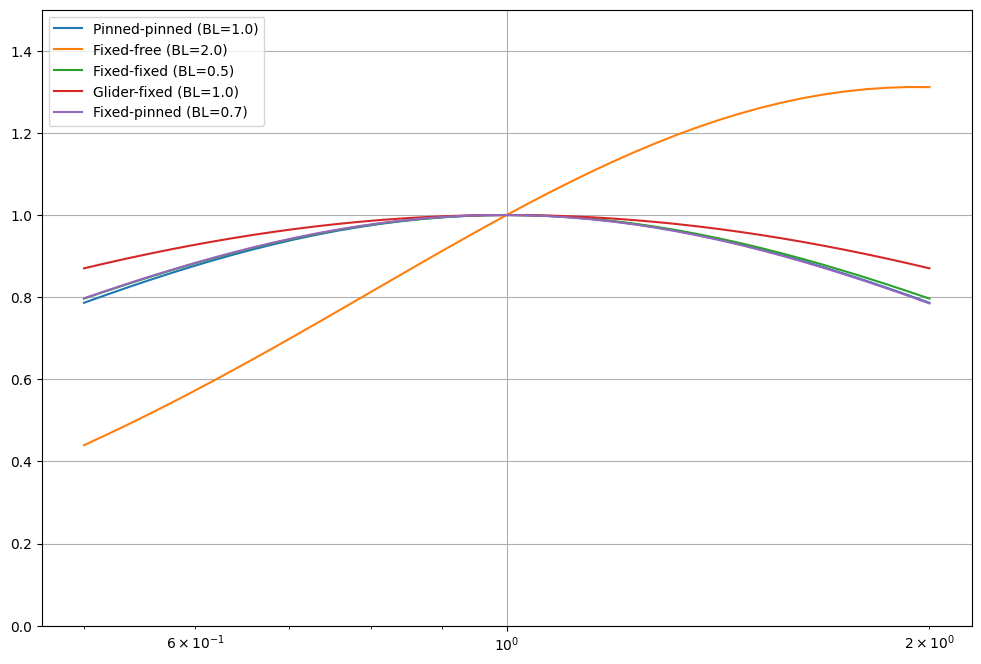

In [155]:
def get_buckling_load_rmid_alpha(rmid, alpha, constrained_dofs):
    rbot = 2 * rmid / (1+1/alpha)
    rtop = 2 * rmid / (1 + alpha)

    K = assemble_stiffness(9e9, rbot, rtop, 10.0, 10, beam_stiffness)
    Kg = assemble_stiffness(9e9, rbot, rtop, 10.0, 10, beam_stiffness_geometric)
    K = apply_boundary_conditions(K, constrained_dofs)
    Kg = apply_boundary_conditions(Kg, constrained_dofs)

    return get_buckling_load(K, Kg)

friendly_names = ['Pinned-pinned (BL=1.0)', 'Fixed-free (BL=2.0)', 'Fixed-fixed (BL=0.5)', 'Glider-fixed (BL=1.0)', 'Fixed-pinned (BL=0.7)']
def plot_alphas(alphas, cases=(0,1,2,3,4)):
    fig,ax = plt.subplots(figsize=(12,8))
    for i in cases:
        buckl_loads = np.array([get_buckling_load_rmid_alpha(0.11, alpha, constrained_dofs[i]) for alpha in alphas])
        ax.plot(alphas, buckl_loads/buckl_loads[np.where(alphas==1)[0]], label=friendly_names[i])
        ax.set_xscale('log') # Makes the distance between 0.5 and 1 the same as between 1 and 2, which it should in this case
        ax.set_ylim((0, 1.5))
        ax.legend()
        ax.grid()
    return fig,ax,alphas

plot_alphas(np.logspace(-1, 1, 41, base=2))
plt.show()

The above is a plot of the (normalized) buckling loads for alphas between 0.5 and 2.0, that is, the top diameter being twice the bottom diameter on the left and the bottom diameter being twice the top diameter at the right. The average diameter is the same in all cases. 

The one that sticks out is perhaps the least surprising: The fixed-free column has the greatest moment at the bottom (this is obvious from looking at the shape), so the bending stiffness at the bottom matters much more than that at the top and the buckling load increases with alpha.. 

For the other ones, the buckling load starts to fall off to about 90% (glider-fixed) or 80% (fixed-fixed, fixed-pinned and pinned-pinned) as the diameter ratio goes to 0.5 or 2.0. The curve for the fixed-pinned column is almost completely symmetric, even though its boundary conditions are not. The other ones have symmetric boundary conditions, so they are expected to be symmetric.

To me, this suggests that using the average radius to calculate a buckling load with a correction of something like 
$f_1 = 1 - 0.2(\alpha - 1)^{1.5}$ is reasonable design in every case except the fixed-free one. For the purposes of calculating $f_1$ we have redefined $\alpha$ as $max(\alpha, \frac{1}{\alpha})$ which is great; we no longer care which of the top or bottom diameter is the greatest. 

This is accurate for 3/5 canonical cases, conservative for one and completely off for the case of the fixed-free column. For the fixed-free column, a correction of $f_2 = 1.315 - 0.315(2 - \alpha)^{2.5}$ is fairly accurate although it is nowhere near as nice as the $f_1$.

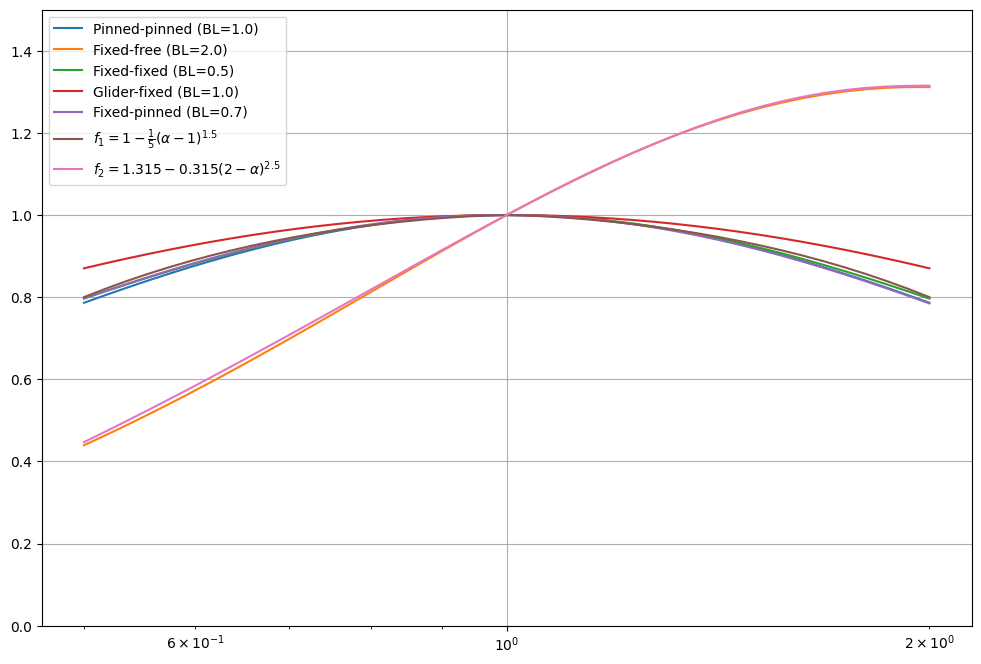

In [170]:
fig,ax,alphas = plot_alphas(np.logspace(-1, 1, 41, base=2))
alphas_ = np.maximum(alphas, 1/alphas)
f1 = 1 - (alphas_ - 1)**1.5/5
ax.plot(alphas, f1, label=r'$f_1 = 1 - \frac{1}{5}(\alpha - 1)^{1.5}$')

f2 = 1.315 - 0.315*(2 - alphas)**2.5
ax.plot(alphas, f2, label=r'$f_2 = 1.315 - 0.315(2 - \alpha)^{2.5}$')

ax.legend()
plt.show()

## Conclusion

It turns out that buckling load of a circular pole with a variable diameter can be computed using the average diameter and adjusted by a factor $f_1 = 1 - \frac{1}{5}(max(\alpha, \frac{1}{\alpha}) - 1)^{1.5}$ in most cases, or $f_2 = 1.315 - 0.315(2 - \alpha)^{2.5}$ in the base of a fixed-free column, where $\alpha$ is the ratio of the bottom to the top diameter. 

When using software that requires the user to specify buckling lengths to perform design checks, we can instead adjust the buckling length by multiplying it with $\frac{1}{\sqrt{f}}$ where we are taking the square root because the buckling length appears squared in the formula for the buckling load. This is assuming that the program performs its design check in some waty that is akin to using the Euler formula (it probably does). 